In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# Read the data
reports = pd.read_csv("scraped data for LDA/naturaldisaster1y.csv")
reports.head()
reports.info()

# Our spaCy model:
nlp = en_core_web_md.load()

# Tags we want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

reports['Description'] = reports['Description'].astype(str)
for description in nlp.pipe(reports['Description']):
   proj_tok = [token.lemma_.lower() for token in description if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

# Add tokens to new column
reports['tokens'] = tokens
reports['tokens']

# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         680 non-null    object
 1   Title        680 non-null    object
 2   Description  680 non-null    object
 3   Link         680 non-null    object
 4   Datetime     680 non-null    object
dtypes: object(5)
memory usage: 26.7+ KB
{'address': 0, 'advocacy': 1, 'conference': 2, 'conservative': 3, 'expand': 4, 'flex': 5, 'found': 6, 'friday': 7, 'group': 8, 'liberty': 9, 'muscle': 10, 'national': 11, 'nomination': 12, 'parent': 13, 'philadelphia': 14, 'political': 15, 'presidential': 16, 'republican': 17, 'reuters': 18, 'right': 19, 'rival': 20, 'year': 21, 'air': 22, 'canadian': 23, 'cause': 24, 'fourth': 25, 'half': 26, 'heat': 27, 'july': 28, 'long': 29, 'poor': 30, 'population': 31, 'precaution': 32, 'quality': 33, 'relentless': 34, 'urge': 35, 'wave': 36, 'weekend': 37, 'wildfire': 38,

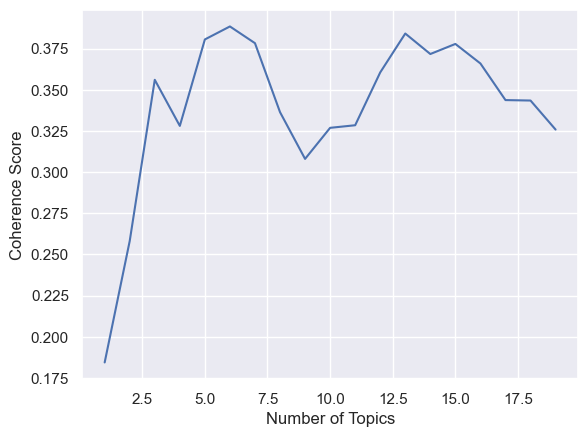

In [3]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [4]:
coherence_lda = cm.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.325773393827236


In [5]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=6, workers = 4, passes=100)

In [6]:
# Print topics
lda_model.print_topics(-1)

[(0,
  '0.038*"wildfire" + 0.023*"reuters" + 0.014*"say" + 0.013*"canada" + 0.012*"province" + 0.011*"weather" + 0.011*"tuesday" + 0.010*"southern" + 0.010*"climate" + 0.010*"year"'),
 (1,
  '0.080*"earthquake" + 0.058*"turkey" + 0.035*"say" + 0.033*"syria" + 0.019*"devastating" + 0.016*"monday" + 0.016*"aid" + 0.015*"people" + 0.015*"week" + 0.014*"month"'),
 (2,
  '0.027*"reuters" + 0.018*"people" + 0.017*"city" + 0.016*"volcano" + 0.015*"thousand" + 0.014*"flooding" + 0.013*"cause" + 0.012*"earthquake" + 0.012*"landslide" + 0.012*"authority"'),
 (3,
  '0.029*"flooding" + 0.026*"rain" + 0.024*"reuters" + 0.019*"damage" + 0.015*"magnitude" + 0.015*"say" + 0.014*"earthquake" + 0.014*"people" + 0.013*"heavy" + 0.013*"home"'),
 (4,
  '0.046*"hurricane" + 0.034*"reuters" + 0.031*"storm" + 0.022*"say" + 0.021*"power" + 0.020*"florida" + 0.019*"people" + 0.019*"ian" + 0.014*"wednesday" + 0.014*"mexico"'),
 (5,
  '0.052*"president" + 0.030*"reuters" + 0.028*"washington" + 0.025*"biden" + 0.0

In [7]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [8]:
# Save the report
pyLDAvis.save_html(lda_display, 'saved html/naturaldisaster1y.html')

              x         y  topics  cluster       Freq
topic                                                
1      0.021968  0.254265       1        1  20.418522
4      0.088924 -0.109166       2        1  19.564813
3      0.098643 -0.078588       3        1  18.163320
0     -0.006501 -0.033040       4        1  15.956760
5     -0.312189 -0.036343       5        1  14.812575
2      0.109155  0.002871       6        1  11.084012


Text(0, 0.5, 'Y Coordinate')

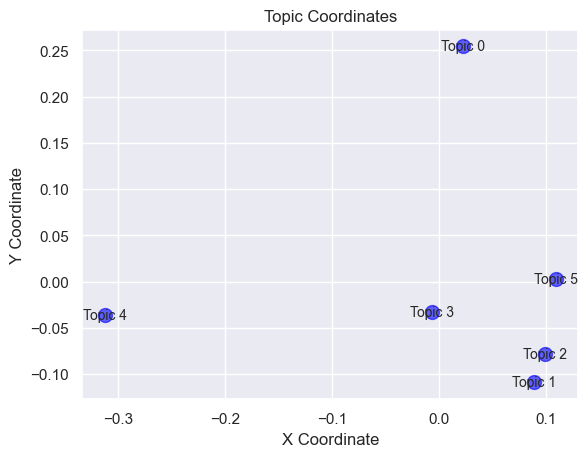

In [9]:
# Access the topic coordinates
topic_coordinates = lda_display.topic_coordinates

# Access the ordering of topics in the visualization
topic_order = lda_display.topic_order
print (topic_coordinates)

# Convert topic coordinates to NumPy array
topic_coordinates_array = topic_coordinates.values

# Create a scatter plot of the topic coordinates
plt.scatter(topic_coordinates_array[:, 0], topic_coordinates_array[:, 1], marker='o', c='blue', s=100, alpha=0.6)

# Add labels to the scatter plot
for topic, (x, y, *_) in enumerate(topic_coordinates_array):
    plt.text(x, y, f'Topic {topic}', fontsize=10, ha='center', va='center')

# Set plot title and axis labels
plt.title('Topic Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [10]:
reports['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(reports['Description']))]
reports.topic.value_counts()

topic
0    488
1     75
2     42
3     36
4     28
5     11
Name: count, dtype: int64

In [11]:
# Associate topics with datetime
reports['topic'] = [sorted(lda_model[corpus[text]], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(reports['Description']))]
reports['topic'] = reports['topic'].astype(int)

# Merge topics with corresponding datetime
topics = lda_model.print_topics(num_topics=7, num_words=5)
topics_dict = {topic[0]: topic[1] for topic in topics}
reports['topic_words'] = reports['topic'].map(topics_dict)

# Resulting DataFrame with topics associated with datetime
print(reports[['Datetime', 'topic', 'topic_words']])

                      Datetime  topic   
0    2023-06-30 18:50:00+00:00      5  \
1    2023-06-30 14:18:00+00:00      0   
2    2023-06-30 08:47:00+00:00      1   
3    2023-06-30 01:01:00+00:00      4   
4    2023-06-29 19:07:00+00:00      3   
..                         ...    ...   
675  2022-07-03 08:49:00+00:00      2   
676  2022-07-03 05:38:00+00:00      3   
677  2022-07-02 19:22:00+00:00      3   
678  2022-07-01 15:21:00+00:00      2   
679  2022-07-01 02:16:00+00:00      4   

                                           topic_words  
0    0.052*"president" + 0.030*"reuters" + 0.028*"w...  
1    0.038*"wildfire" + 0.023*"reuters" + 0.014*"sa...  
2    0.080*"earthquake" + 0.058*"turkey" + 0.035*"s...  
3    0.046*"hurricane" + 0.034*"reuters" + 0.031*"s...  
4    0.029*"flooding" + 0.026*"rain" + 0.024*"reute...  
..                                                 ...  
675  0.027*"reuters" + 0.018*"people" + 0.017*"city...  
676  0.029*"flooding" + 0.026*"rain" + 0.024*"reute

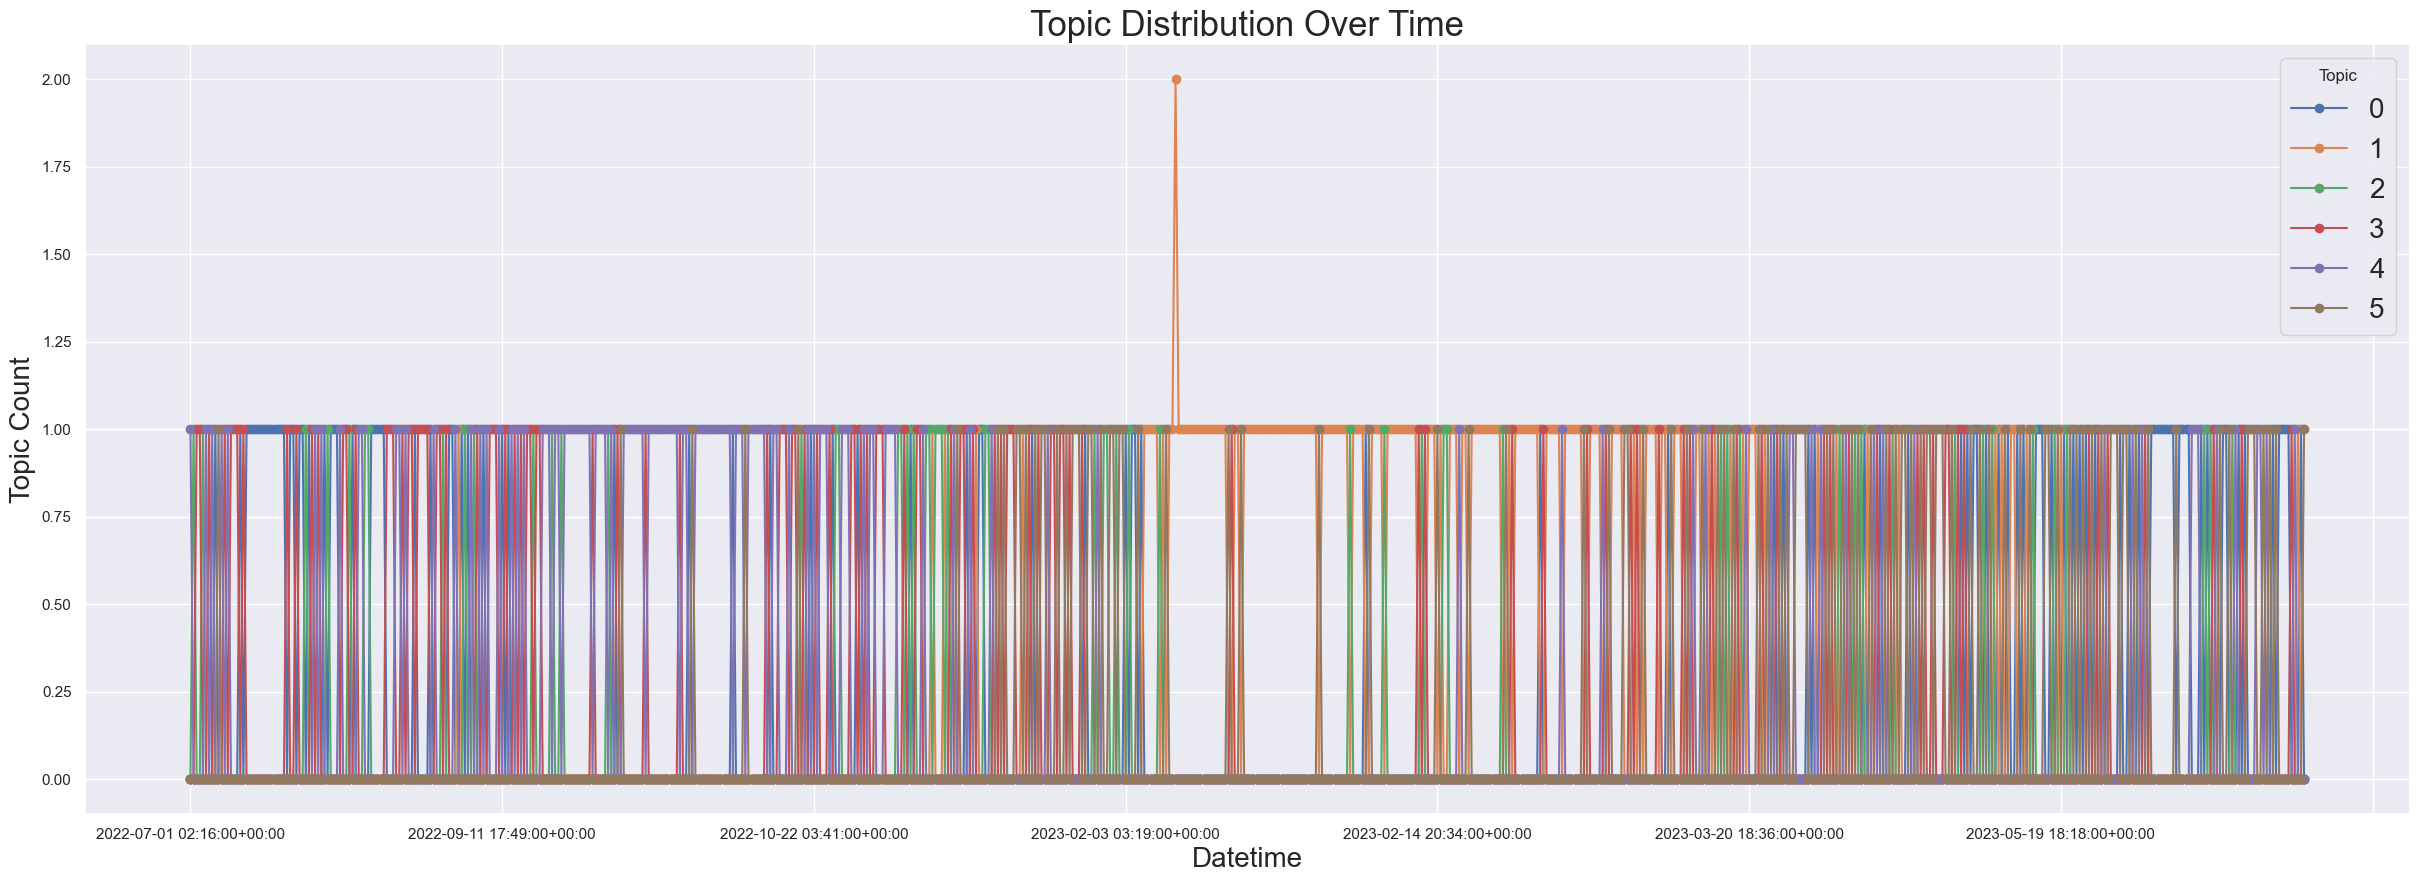

In [12]:
# Group the data by datetime and topic
grouped_data = reports.groupby(['Datetime', 'topic']).size().unstack().fillna(0)

# Plotting the distribution of topics over time
grouped_data.plot(kind='line', figsize=(30, 10), marker='o')

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=25)
plt.xlabel('Datetime', fontsize=20)
plt.ylabel('Topic Count', fontsize=20)
plt.legend(title='Topic', loc='upper right', fontsize=20)

# Show the plot
plt.show()